# 時系列データ予測アルゴリズム N-BEATS による PM2.5の予測

## 概要
時系列データライブラリの GluonTS (バックエンドは MXNet) を利用して時系列データを予測します。このノートブックでは北京におけるPM2.5の変化を予測します。アルゴリズムは以下の N-BEATS を利用します。

- N-BEATS
```
B.N. Oreshkin, D. Carpov, N. Chapados, Y. Bengio
N-BEATS: Neural basis expansion analysis for interpretable time series forecasting, ICLR 2020.
https://arxiv.org/abs/1905.10437
```

## ファイル構造
- pm25_gluonts.ipynb: src にある各機械学習のスクリプトをSageMakerで実行するためのノートブック
- src: 各アルゴリズムの学習・デプロイのコードのフォルダ
  - n_beats_single.py
  - requirements.txt (学習・推論用コンテナに GluonTS をインストールするために必要) 

## データの準備
まずデータを準備しましょう。データセットは UCI の Machine Learning Repository にあるものを利用します。

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015).  
Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating.  
Proceedings of the Royal Society A, 471, 20150257.  

まずデータをダウンロードして `./data` に保存しましょう。

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv -P ./data

csv ファイルを読み込んで、pandas を利用してデータを見てみましょう。

In [2]:
import pandas as pd
data = pd.read_csv('./data/PRSA_data_2010.1.1-2014.12.31.csv', sep=',')
data.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


このままでは時系列データの予測には利用しづらいところがありますのでデータを修正しましょう。
- pm2.5 のところに NaN という値が見えますが、このような欠損値はそのまま予測には利用できませんので、NaNを含む行を `dropna` で削除します。
- 日時が各列に渡ってばらばらになっています。ここでは `year`, `month`, `day`, `hour` をまとめて `time` という列を設けます。最後に `set_index` で `time` を index にしましょう。
- `cbwd` の列は文字列（カテゴリ変数）なので数値に変換しましょう。それぞれ NE や NW といった風向きごとに列を用意して、NE だったところは NE の列の値が 1, それ以外は 0となるような one-hot encoding を行います。 `get_dummies`がこれに対応します。
- 不要な列は `drop` で削除します。


In [ ]:
data.dropna(inplace = True)
data["hour"] = data.hour.map("{:02}".format) + ":00:00"
data["time"] = pd.to_datetime(data["year"].astype(str) + '/'
                              + data["month"].astype(str) + '/'
                              + data["day"].astype(str) + '/'
                              + data["hour"].astype(str))
data.drop(['No','year','month','day','hour'], axis = 1, inplace = True)
data = pd.get_dummies(data, columns = ['cbwd'])
data.set_index('time',inplace =True)
data

## S3へのデータのアップロード

いま CSV ファイルはこのノートブックインスタンスに保管されているので、学習用インスタンスからアクセスできるようにストレージにアップロードする必要があります。Amazon S3, Amazon EFS, Amazon FSx for Lustre などに対応していますが、ここでは Amazon S3 にその CSV ファイルをアップロードします。

アップロードするまえに、学習用データとテストデータを分けておきます。今回は最後の1ヶ月である 2014年12月をテストデータにしましょう。SageMaker の学習に必要なものは、学習データのみですので、ここでは `train.csv` と保存して S3 にアップロードします。アップロードは `sagemaker_session.upload_data` という関数で行えます。

実行後にアップロード先が表示されますので確認しましょう。

In [ ]:
import sagemaker

train_data = data[:"2014-11-30 23:00:00"]
test_data = data["2014-12-01 00:00:00":]
train_data.to_csv("./train.csv")

sagemaker_session = sagemaker.Session()
input_data = sagemaker_session.upload_data("./train.csv", key_prefix="beijing_pm25")
print("File is uploaded to {}".format(input_data))

## 学習の実行

学習を実行するため、学習に必要な情報をすべて与えて`estimator`を定義します。必要な情報として例えば以下のようなものがあります。

- entry_point: 学習を実行するスクリプトのパス
- source_dir: 学習スクリプトを保管するディレクトリ (python library を requirements.txt に保管することでインストール可能)
- train_instance_type: 学習に利用するインスタンスのタイプ
- train_instance_count: 学習に利用するインスタンスの数 (GluonTS ではまだ分散学習に対応していません)
- hyperparameters: ここで指定した値は、entry_point に引き継がれます

`estimator`の定義ができれば、学習データのパス`input_data`を与えて`fit`を呼び出して実行しましょう。このパスのファイルが、学習用インスタンスにダウンロードされて学習に利用されます。パスを`{'XXXX': input_data}` と渡すと、学習用インスタンスにおいて、保存先フォルダは`os.environ['SM_CHANNEL_XXXX']`から取得できます (今回は XXXX = train です)。 

### 学習スクリプトの中身
n_beats_single.py を試しにみてみましょう。スクリプトは大きく2つにわかれています。実装方法の詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html)を御覧ください。
1. `if __name__ == '__main__':` で囲まれている部分が学習時に実行されます。
1. `def model_fn(model_dir):` はデプロイ時に実行されます。

ここではまず`if __name__ == '__main__':`のみを見ていきます。

#### 1. ハイパーパラメータの受け取り

学習用インスタンスでは
```
python n_beats_single.py --batch-size 32 --epochs 10
```
のように、ノートブックからのハイパーパラメータを引数にスクリプトが実行されます。そこで、これらを受け取るためのargparseを利用します。

```
parser.add_argument('--batch-size', type=int, default=32)
parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--learning-rate', type=float, default=0.001)
parser.add_argument('--columns', type=str, default='pm2.5')
```

以下のハイパーパラメータを利用します。
- batch_size: 学習に利用するバッチサイズ
- epochs: エポック数 (学習のイテレーション回数、以下のスクリプトでは100としています。)
- learning_rate: 学習率。大きいほど1回の学習による更新が大きいですが、安定性に欠ける場合があります。
- columns: 今回予測対象とする列 (デフォルトは `pm2.5`, 複数予測したい場合はカンマ区切りで例えば `pm2.5,DEWP` とします。
- prediction_length: 予測の期間（時間ステップ数）
- context_length: 予測に利用する期間（時間ステップ数）
- frequency: 時間ステップの単位（今回は1時間）

#### 2. データの読み込み

データは`os.environ['SM_CHANNEL_train']`のフォルダに保存されます。ファイル名は train.csv としているので、スクリプト内でも指定して、pandas でデータを読み込んでいます。ハイパーパラメータで columns に指定したものを取り出して、gluonts のためのデータセットを作ります。

```
data = pd.read_csv(os.path.join(train_path, "train.csv"),
                   sep=',', 
                   index_col=0,
                   parse_dates=True)
training_data = ListDataset(
        [{"start": data.index[0], 
          "target": data[columns]}],
        freq = freq
)
```

#### 3. 学習

学習は非常にシンプルで、実行したいモデルを呼び出して、各種パラメータを指定するだけです。指定が終われば、`train`関数でデータセットに対して学習を開始します。

```
estimator = NBEATSEstimator(
            freq=freq, 
            ...)
predictor = estimator.train(training_data)
```

パラメータは **1. ハイパーパラメータの受け取り** で指定したパラメータを利用可能です。


#### 4. モデルの保存

学習が終わると学習用インスタンスは消えてしまうので、モデルを指定のフォルダにダウンロードして、S3にアップロードします。保存先は`os.environ['SM_MODEL_DIR']`で取得することができます。ここにモデルを保存しておくと、学習用インスタンスが消える前に、モデルをS3にアップロードすることができます。

GluonTS では以下のコードでモデルの保存が可能です。`from pathlib import Path`が必要です。

```
predictor.serialize(Path(model_dir))
```

In [ ]:
from sagemaker.mxnet import MXNet
role = sagemaker.get_execution_role()

script_name = "n_beats_single.py"

estimator = MXNet(entry_point = script_name,
                  source_dir="src",
                  role = role,
                  framework_version="1.6.0",
                  py_version='py3',
                  train_instance_type = "ml.p3.2xlarge",
                  train_instance_count =1,
                  distributions={'parameter_server': {'enabled': True}},
                  hyperparameters={
                      "batch-size":32,
                      "epochs":100,
                      "learning-rate":0.001,
                      "columns":'pm2.5', 
                      "prediction-length": 12,
                      "context-length": 168,
                  })
estimator.fit({'train':input_data})

### モデルのデプロイ

estimator から deploy を行うと、先程学習したモデルをデプロイすることができます。デプロイする際には、どのモデルを推論に利用するか、前処理、後処理をどうするか等を実装することができます。実装方法の詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#deploy-mxnet-models)を御覧ください。

推論用のコードでは、最低限、推論に利用するモデルの指定を`def model_fn(model_dir)`で行う必要があります。ここでは、S3に保存されたモデルが推論用コンテナの `model_dir` に保存されているので、ここから読み込むコードを実装します。

```python
def model_fn(model_dir):
    return Predictor.deserialize(Path(model_dir))
```

加えてどのような予測を行うかを `def transform_fn(net, data, input_content_type, output_content_type)` で実装することができます。GluonTS用にDataSetを作成して `predict` で予測を行うことができます。

```python
def transform_fn(net, data, input_content_type, output_content_type):
    
    try:
        data = json.loads(data) 
        
        #How many time-series are included?
        N = len(data["value"])
        
        #Create dataset
        test_data = ListDataset(
            [{"start": datetime.strptime(data["index"], "%Y-%m-%d %H:%M:%S"), 
              "target": np.array(data["value"][n])} for n in range(N)
            ],
            freq = data["freq"]
        )
        
        # prediction
        forecast_it = net.predict(test_data)
        forecasts = list(forecast_it)
        
        result = []
        for n in range(N):
            result.append(forecasts[n].samples.tolist())
        response_body = json.dumps(result)
        return response_body, output_content_type
    
    except Exception as e:
        print(e)
        return json.dumps(str(e)), output_content_type
```

In [ ]:
predictor = estimator.deploy(instance_type="ml.m4.xlarge", initial_instance_count=1)

### 推論の実行

`predictor.predict` で推論を実行することができます。ここでは、テストデータのうち `feed_start_t` から `pred_start_t` までのデータを送ります。以下のスクリプトでは、

- feed_start_t = 0
- pred_start_t = feed_start_t + 168

となっていますので、テストデータの最初の1週間をモデルに入力して、その12時間の予測を行っています。もし開始時間をずらすばあいは、feed_start_t に異なる値を入れてみてください。

dict 形式のデータを送ることで predictor が json形式に dumpして情報を送ります。この情報は`transform_fn`で受け取られますので、json.loadsして受け取りましょう。結果は prediciton に 2次元のリストで格納されます。そのshape は、予測したい時系列データの本数 X 予測の期間 となります。

最後に各時系列データについてグラフ化してみましょう。グラフは、`end_t` から `graph_range` までさかのぼって描画されるので、幅を変えたい場合は、`graph_range` を変えてみてください。

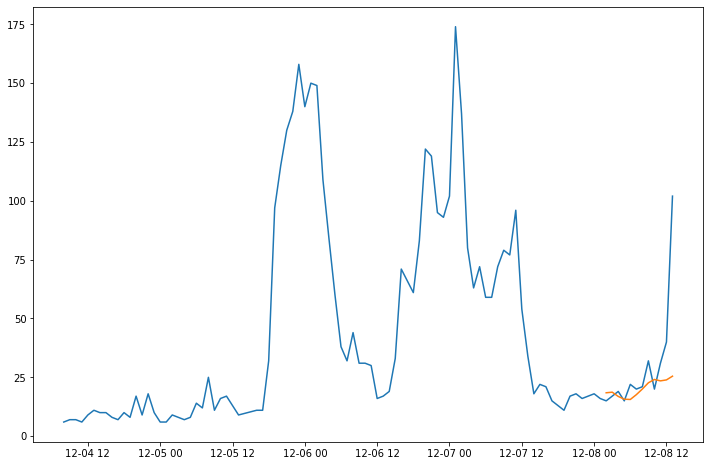

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

prediction_columns = ['pm2.5']

feed_start_t = 0
pred_start_t = feed_start_t + 168
end_t = pred_start_t + 12

graph_range = 100
graph_start_t = max(end_t - graph_range,0)

test_data_target = test_data[feed_start_t:pred_start_t][prediction_columns]
prediction = predictor.predict(
    {"index": str(test_data.index[0]),
     "value": test_data_target.values.transpose().tolist(),
     "freq": "1H",
     "n_sample": 1,
    }
)

fig, axs = plt.subplots(len(prediction_columns), figsize=(12,8))

if len(prediction_columns)> 1:
    for i,p in enumerate(prediction_columns):
        axs[i].plot(test_data[graph_start_t:end_t].index, test_data[graph_start_t:end_t][p].values)
        axs[i].plot(test_data[pred_start_t:end_t].index, prediction[i][0])
else:
    axs.plot(test_data[graph_start_t:end_t].index, test_data[graph_start_t:end_t][prediction_columns[0]].values)
    axs.plot(test_data[pred_start_t:end_t].index, prediction[0][0])

## Rolling Forecast の実行

上記の12時間先を予測する問題は難しいことがあります。そこで1時間ずつ予測を行い、直近の予測のみを採用していく Rolling Forecast を試してみます。

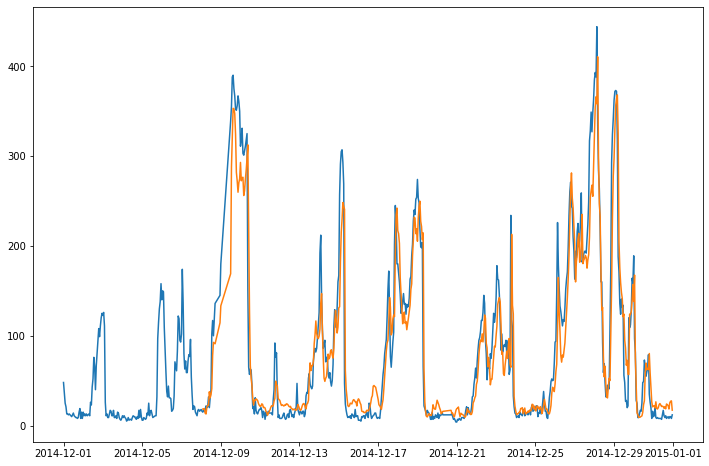

In [30]:
prediction_columns = ['pm2.5']
rolling_forecast = []

for st in range(len(test_data.index) -168):
    feed_start_t = st
    pred_start_t = feed_start_t + 168
    end_t = pred_start_t + 12

    test_data_target = test_data[feed_start_t:pred_start_t][prediction_columns]
    prediction = predictor.predict(
        {"index": str(test_data.index[0]),
         "value": test_data_target.values.transpose().tolist(),
         "freq": "1H",
         "n_sample": 1,
        }
    )
    
    pred_next = prediction[0][0][0] # Takes the 1st element of the 1st array correspondig to 'pm2.5'
    rolling_forecast.append(pred_next)

fig, axs = plt.subplots(1, figsize=(12,8))
axs.plot(test_data.index, test_data[prediction_columns[0]].values)
axs.plot(test_data[168:].index, np.array(rolling_forecast)) 

12時間ごとに予測するよりは上手く行ったのではないでしょうか。次は6時間ごとに予測してみます。スパイクに対する予測の追従がやや遅れているようにもみえます。

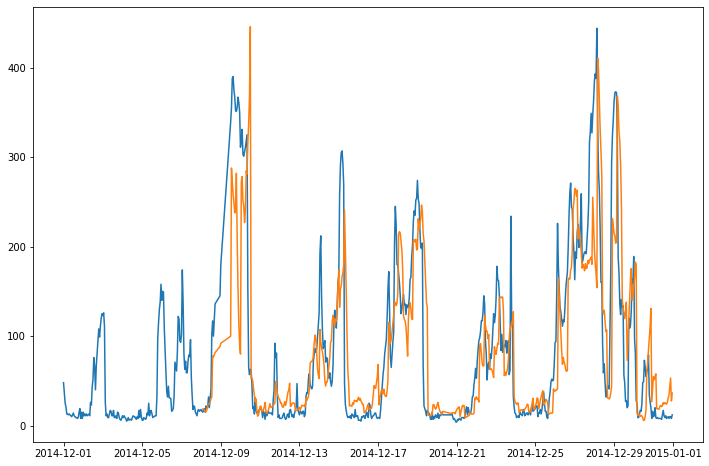

In [46]:
prediction_columns = ['pm2.5']
rolling_forecast = []

interval = 6
for st in range(0, len(test_data.index)-168, interval):
    feed_start_t = st
    pred_start_t = feed_start_t + 168
    end_t = pred_start_t + 12

    test_data_target = test_data[feed_start_t:pred_start_t][prediction_columns]
    prediction = predictor.predict(
        {"index": str(test_data.index[0]),
         "value": test_data_target.values.transpose().tolist(),
         "freq": "1H",
         "n_sample": 1,
        }
    )
    
    pred_next = prediction[0][0][0:interval]
    rolling_forecast.append(pred_next)

fig, axs = plt.subplots(1, figsize=(12,8))
axs.plot(test_data.index, test_data[prediction_columns[0]].values)
axs.plot(test_data[168:].index, np.array(rolling_forecast).flatten()[:len(test_data[168:].index)]) 

### エンドポイントの削除

エンドポイント実行中は課金が続きますので、不要な場合は削除します。

In [ ]:
predictor.delete_endpoint()